<a href="https://colab.research.google.com/github/Romulan12/DeepLabv3_Cityscapes/blob/master/DeepLab_MobileNet_Video_with_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Tensorflow

import tensorflow.compat.v1 as tf

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
matplotlib.use('Agg')
import matplotlib.animation as animation

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [0]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [14]:
'''class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map
        '''

'class DeepLabModel(object):\n    """Class to load deeplab model and run inference."""\n\n    FROZEN_GRAPH_NAME = \'frozen_inference_graph\'\n\n    def __init__(self, tarball_path):\n        """Creates and loads pretrained deeplab model."""\n        self.graph = tf.Graph()\n        graph_def = None\n\n        # Extract frozen graph from tar archive.\n        tar_file = tarfile.open(tarball_path)\n        for tar_info in tar_file.getmembers():\n            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):\n                file_handle = tar_file.extractfile(tar_info)\n                graph_def = tf.GraphDef.FromString(file_handle.read())\n                break\n        tar_file.close()\n\n        if graph_def is None:\n            raise RuntimeError(\'Cannot find inference graph in tar archive.\')\n\n        with self.graph.as_default():\n            tf.import_graph_def(graph_def, name=\'\')\n        self.sess = tf.Session(graph=self.graph)\n\n    def run(self, image, INPUT_T

In [0]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]



LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [16]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.compat.v1.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [0]:
result_path = '/content/drive/My Drive/cityscapes/results/video_results/'

In [0]:
matplotlib.use('Agg')

In [0]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()
    #plt.savefig(result_path + 'frame #%d'%index)
   
    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpg')    
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()



In [0]:

def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)

In [20]:
SAMPLE_VIDEO = '/content/drive/My Drive/cityscapes/videos/mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO): 
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('running deeplab on the sample video...')

running deeplab on the sample video...


In [21]:
#coutning number of frames
## import the necessary packages

import cv2
'''
def count_frames(path, override=False):
	# grab a pointer to the video file and initialize the total
	# number of frames read
	video = cv.VideoCapture(path)
	total = 0
	# if the override flag is passed in, revert to the manual
	# method of counting frames
	if override:
		total = count_frames_manual(video)
  # otherwise, let's try the fast way first
	else:
		# lets try to determine the number of frames in a video
		# via video properties; this method can be very buggy
		# and might throw an error based on your OpenCV version
		# or may fail entirely based on your which video codecs
		# you have installed
		try:
			# check if we are using OpenCV 3
			if is_cv3():
				total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
			# otherwise, we are using OpenCV 2.4
			else:
				total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
		# uh-oh, we got an error -- revert to counting manually
		except:
			total = count_frames_manual(video)
	# release the video file pointer
	video.release()
	# return the total number of frames in the video
	return total


def count_frames_manual(video):
	# initialize the total number of frames read
	total = 0
	# loop over the frames of the video
	while True:
		# grab the current frame
		(grabbed, frame) = video.read()
	 
		# check to see if we have reached the end of the
		# video
		if not grabbed:
			break
		# increment the total number of frames read
		total += 1
	# return the total number of frames in the video file
	return total
'''

"\ndef count_frames(path, override=False):\n\t# grab a pointer to the video file and initialize the total\n\t# number of frames read\n\tvideo = cv.VideoCapture(path)\n\ttotal = 0\n\t# if the override flag is passed in, revert to the manual\n\t# method of counting frames\n\tif override:\n\t\ttotal = count_frames_manual(video)\n  # otherwise, let's try the fast way first\n\telse:\n\t\t# lets try to determine the number of frames in a video\n\t\t# via video properties; this method can be very buggy\n\t\t# and might throw an error based on your OpenCV version\n\t\t# or may fail entirely based on your which video codecs\n\t\t# you have installed\n\t\ttry:\n\t\t\t# check if we are using OpenCV 3\n\t\t\tif is_cv3():\n\t\t\t\ttotal = int(video.get(cv2.CAP_PROP_FRAME_COUNT))\n\t\t\t# otherwise, we are using OpenCV 2.4\n\t\t\telse:\n\t\t\t\ttotal = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))\n\t\t# uh-oh, we got an error -- revert to counting manually\n\t\texcept:\n\t\t\ttotal = count_frames_

In [0]:
#num_frames = count_frames(SAMPLE_VIDEO)
num_frames = 40 # 40 frames for simplicity

In [0]:
video = cv.VideoCapture(SAMPLE_VIDEO)

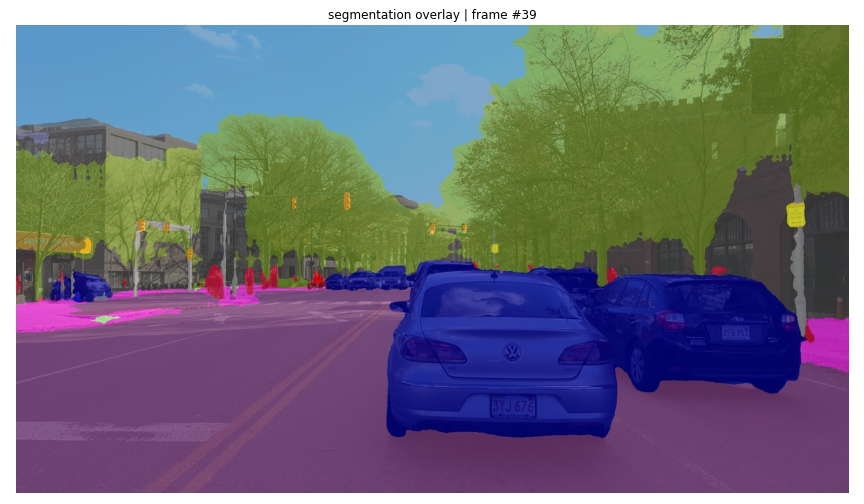

In [24]:
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

In [0]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt

In [28]:
SAMPLE_GT = '/content/drive/My Drive/cityscapes/videos/ground_truth_mit_video/MIT_DriveSeg_sample_gt/'
if not os.path.isfile(SAMPLE_GT): 
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)


downloading the sample ground truth...


In [0]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


In [31]:
#Evaluating the results
print('evaluating on the sample video...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video...


100%|██████████| 30/30 [03:16<00:00,  6.54s/it]

pixel accuracy: 0.8995
mean class IoU: 0.5276
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4104      0.5283  0.1594           0.4487          0.5508        0.8295     0.0474    0.3879  0.9582


In [32]:
#leverage temporal information
print('evaluating on the sample video with temporal smoothing...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []
prev_seg_map_logits = 0

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    
    # Get the logits instead of label prediction
    seg_map_logits = MODEL.run(original_im, OUTPUT_TENSOR_NAME='ResizeBilinear_3:0')
    
    # Add previous frame's logits and get the results
    seg_map = np.argmax(seg_map_logits + prev_seg_map_logits, -1)
    prev_seg_map_logits = seg_map_logits
    
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)
    
class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video with temporal smoothing...


100%|██████████| 30/30 [03:17<00:00,  6.57s/it]

pixel accuracy: 0.8998
mean class IoU: 0.5284
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4064      0.5285   0.158           0.4504           0.551        0.8297     0.0453    0.4008  0.9586
